# 0.0 IMPORTS

In [117]:
import math
import pandas as pd
import numpy  as np
import inflection
import random
import pickle
import warnings
import xgboost as xgb
import seaborn as sns


from boruta               import BorutaPy
from scipy                import stats      as ss
from matplotlib           import pyplot     as plt
from IPython.core.display import HTML
from IPython.display      import Image

from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.ensemble      import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error


warnings.filterwarnings('ignore')

## 0.1 Helper Functions

In [100]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']
        
        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name, 
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )

def mean_percentage_error(y,yhat):
    return np.mean((y-yhat)/y)

def mean_absolute_percentage_error(y,yhat):
    return np.mean(np.abs((y-yhat)/y))


def ml_error(model_name,y,yhat):
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])


def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv' , low_memory=False)
df_store_raw = pd.read_csv('data/store.csv' , low_memory=False)


#merge
df_raw = pd.merge(df_sales_raw , df_store_raw , how='left' , on='Store')

In [5]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1011684,50,6,2013-01-05,4380,372,1,0,0,0,d,a,6260.0,11.0,2009.0,0,NaN,NaN,NaN


# 1.0 Passo 01 -  DESCRICAO DOS DADOS

In [6]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [7]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 
            'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase,cols_old))

df1.columns = cols_new

In [9]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [10]:
print('Number of Rows: {}' .format(df1.shape[0]))
print('Number of columns: {}' .format(df1.shape[1]))

Number of Rows: 1017209
Number of columns: 18


## 1.3 Data Types

In [11]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [12]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [13]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [14]:
df1['competition_distance'].max()

75860.0

In [15]:
#competition_distance              2642
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)
#competition_open_since_month    323348
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'] , axis=1)
                                                                                
#competition_open_since_year     323348
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'] , axis=1)
#promo2_since_week               508031
df1['promo2_since_week']  = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'] , axis=1)
#promo2_since_year               508031
df1['promo2_since_year']  = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'] , axis=1)

#promo_interval                  508031

month_map = {1:'Jan' , 2:'Fev' ,  3: 'Mar' ,  4:'Apr' ,  5:'Mai' ,  6:'Jun' , 7:'Jul' ,  8: 'Aug' ,  9:'Sep' , 10:'Oct' ,  11: 'Nov' ,  12:'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval' , 'month_map']].apply(lambda x: 0 if x['promo_interval']==0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


In [16]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [17]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [18]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)


df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [19]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistics

In [20]:
num_attributes = df1.select_dtypes(include=['int64' , 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64' , 'float64' , 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [21]:
#Central Tendency - mean , median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T


#Dispersion - std , min , max , range , skew , kurtosis
d1 = pd.DataFrame( num_attributes.apply(np.std)).T
d2 = pd.DataFrame( num_attributes.apply(min)).T
d3 = pd.DataFrame( num_attributes.apply(max)).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew())).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis',]
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='sales', ylabel='Density'>

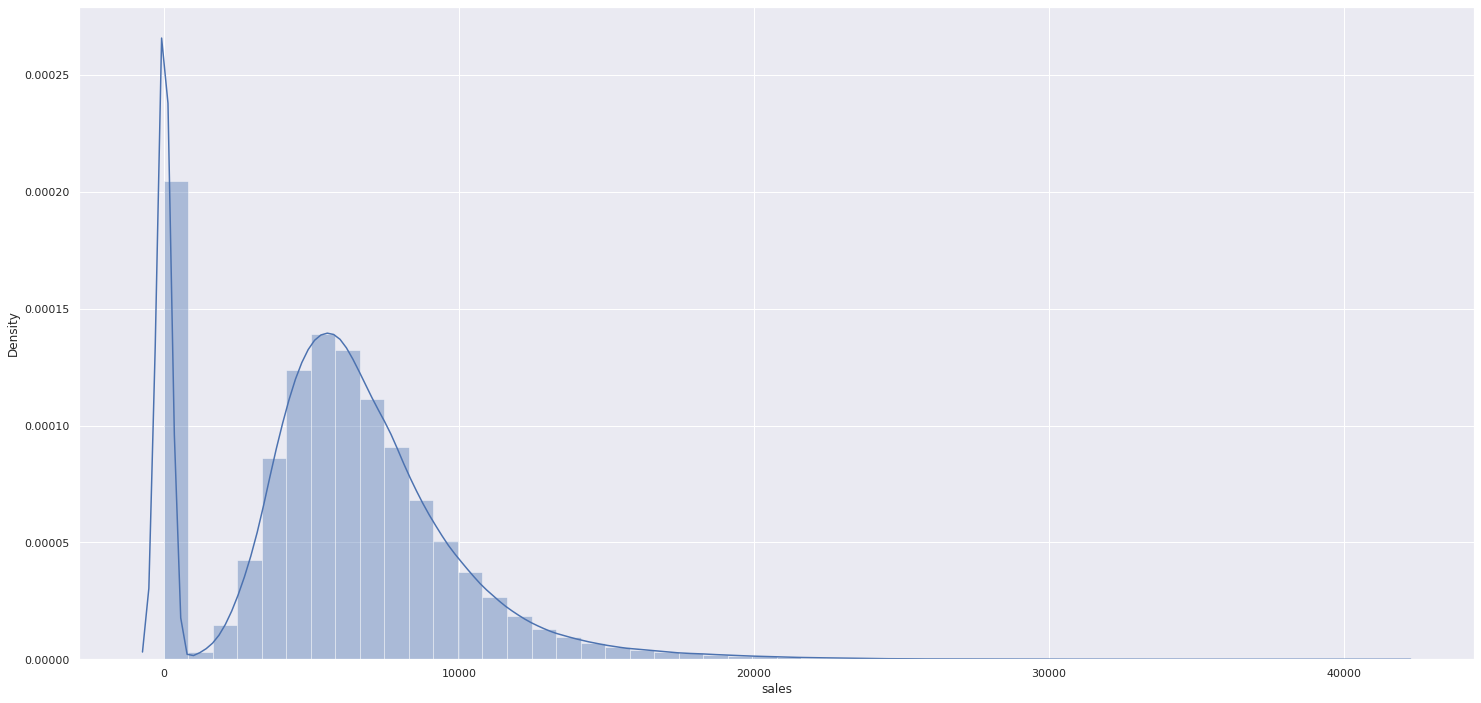

In [22]:
sns.distplot(df1['sales'])

<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

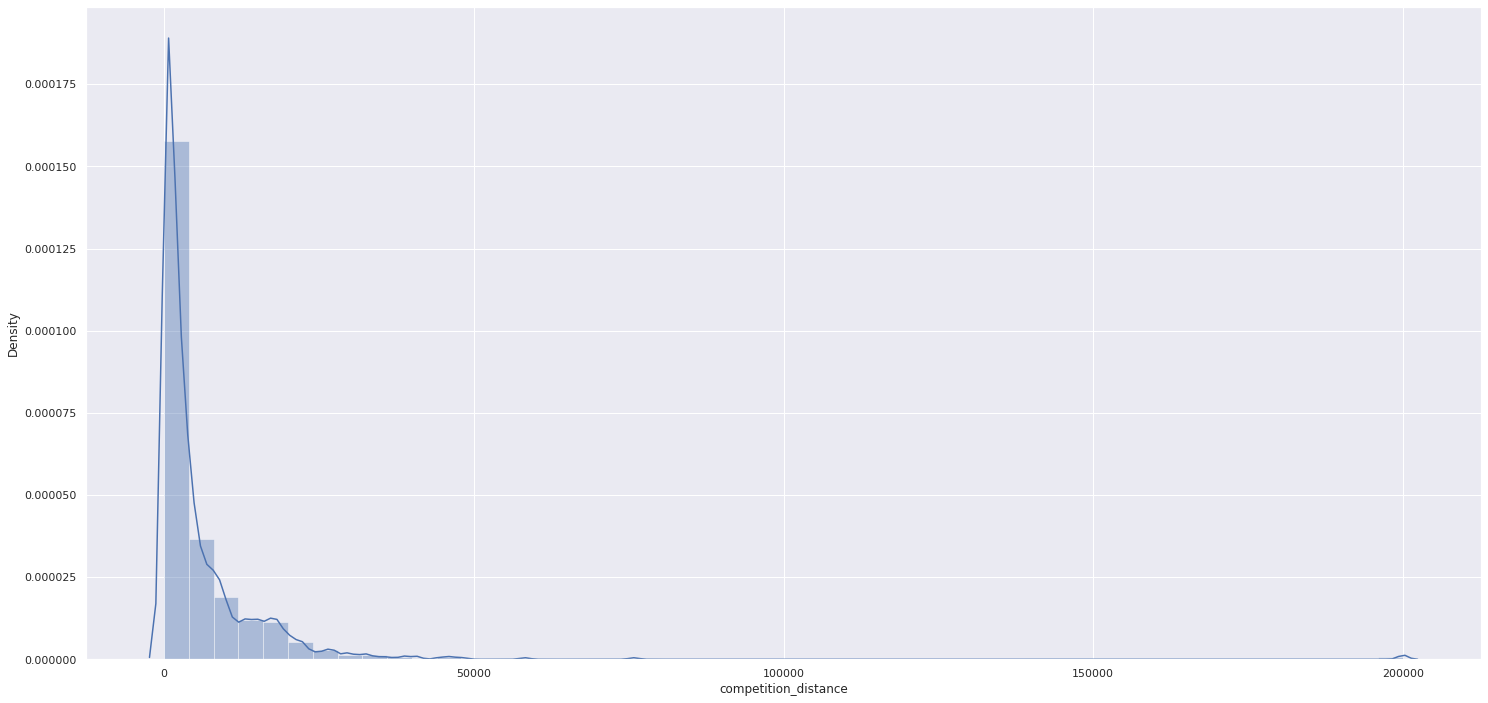

In [23]:
sns.distplot(df1['competition_distance'])

## 1.7.2 Categorical Attributes

In [24]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

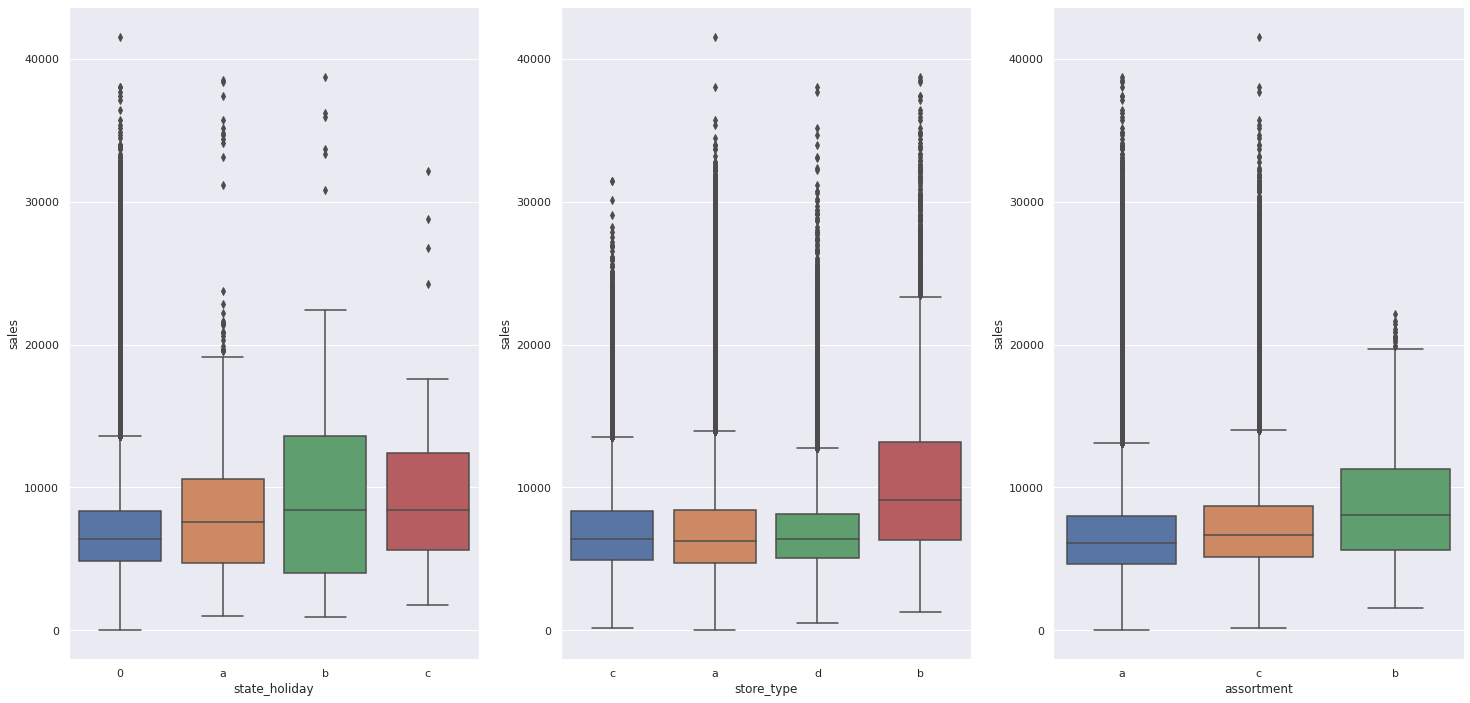

In [25]:
aux1 = df1[(df1['state_holiday'] != 0) & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x = 'state_holiday' , y = 'sales' , data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x = 'store_type' , y = 'sales' , data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x = 'assortment' , y='sales' , data=aux1)

<AxesSubplot:xlabel='assortment', ylabel='sales'>

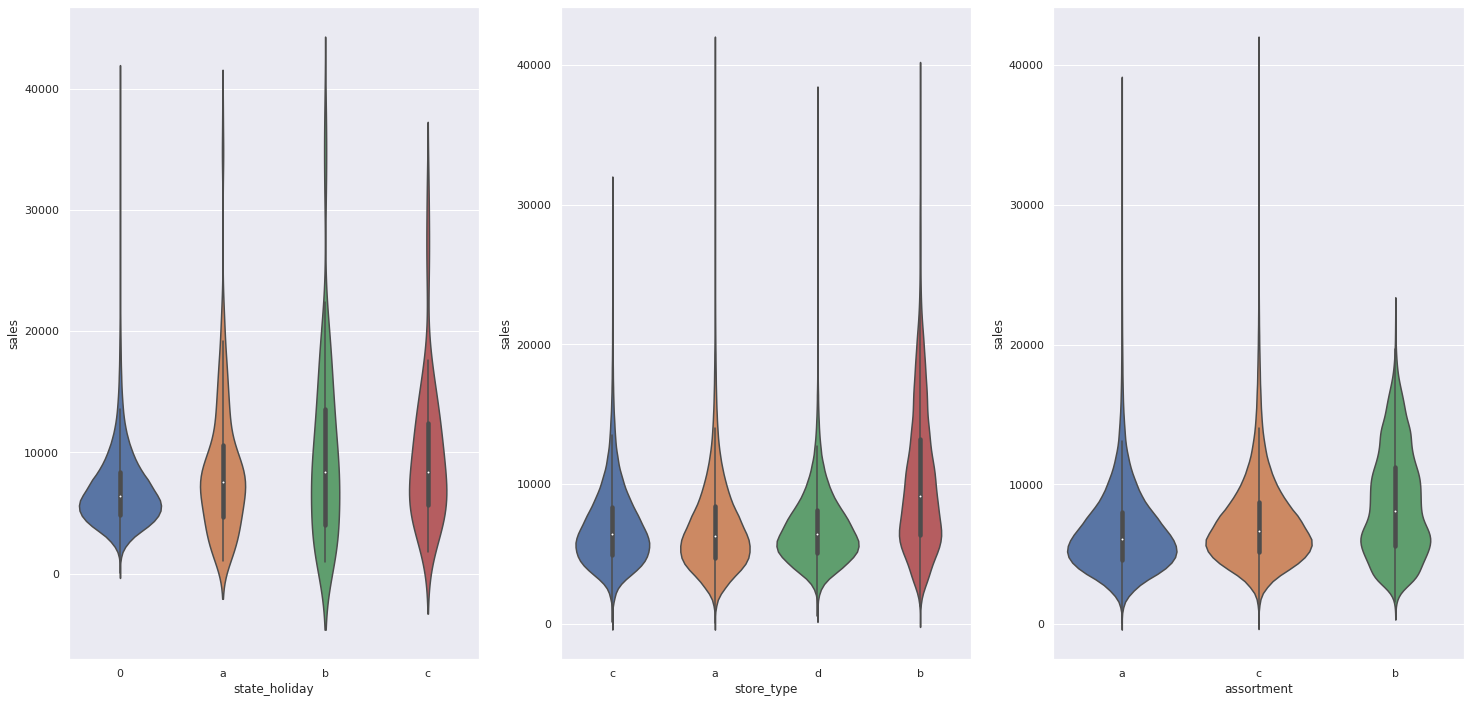

In [26]:
plt.subplot(1,3,1)
sns.violinplot(x='state_holiday' , y='sales' , data=aux1)

plt.subplot(1,3,2)
sns.violinplot(x = 'store_type' , y='sales' , data=aux1)

plt.subplot(1,3,3)
sns.violinplot(x='assortment' , y = 'sales' , data=aux1)

# 2.0 Passo 02 - FEATURE ENGINEERING

In [27]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipótese

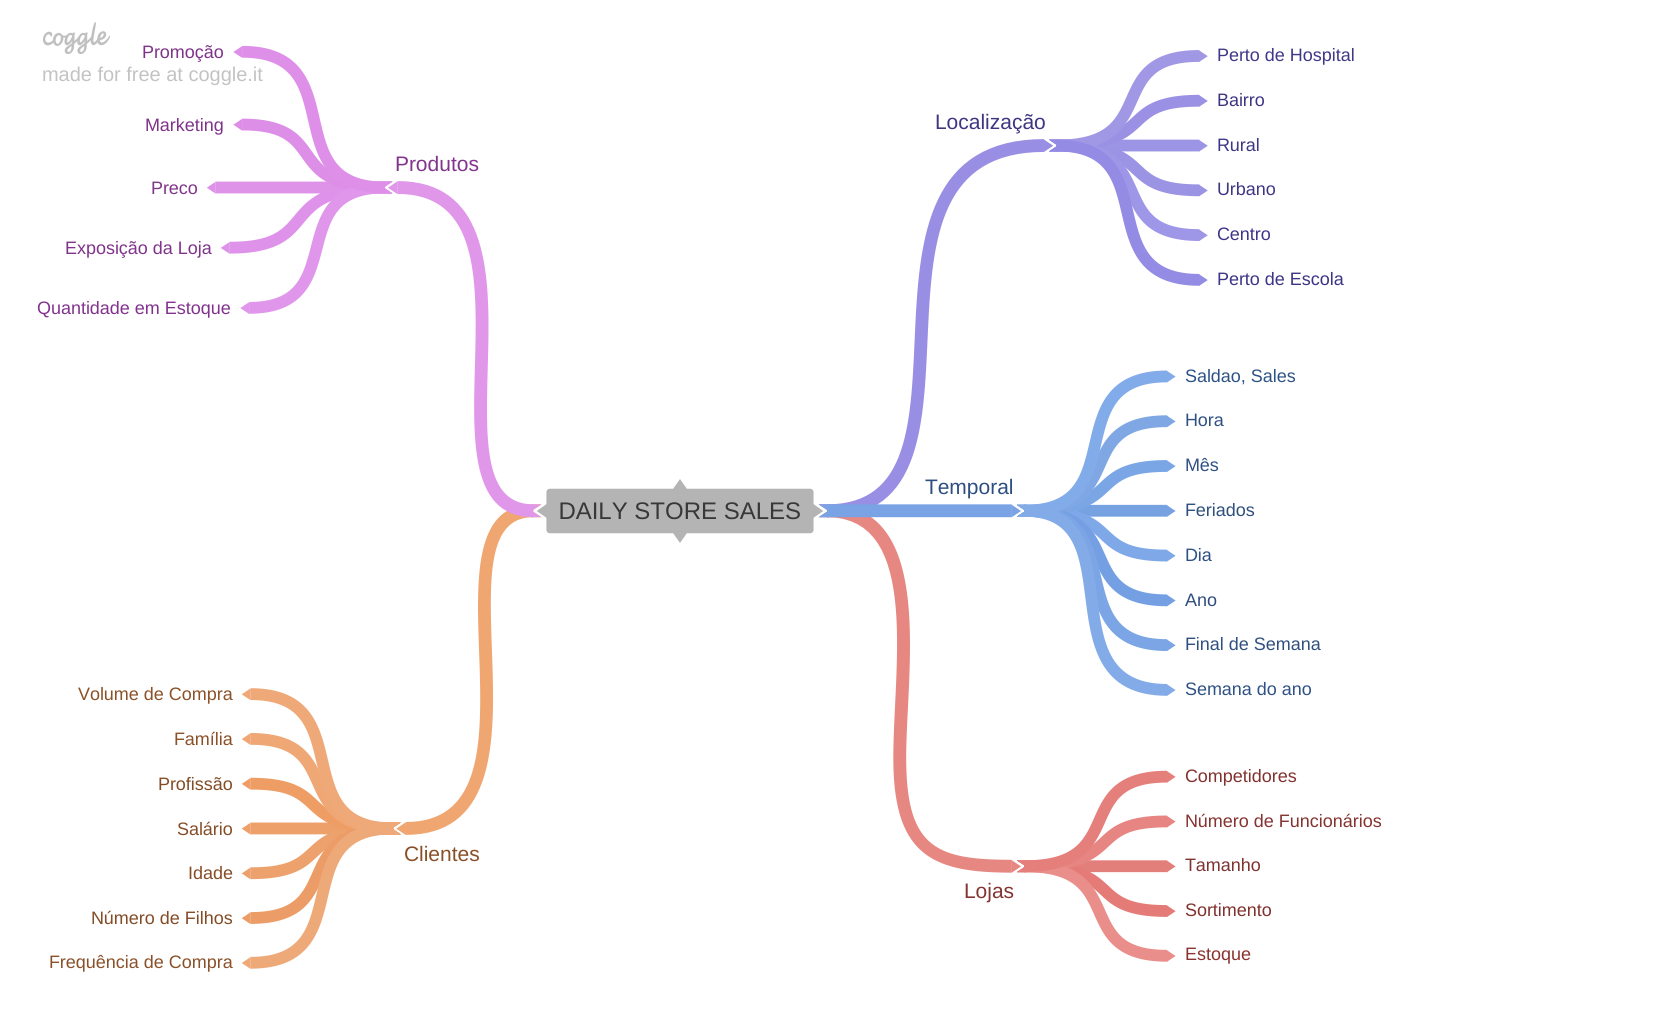

In [28]:
Image('img/MindMapHypotesis.png')

## 2.2 Criação das Hipóteses

### 2.2.1 Hipóteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2 Hipóteses Produto 

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

### 2.3 Lista Final de Hipóteses 

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4 Feature Engineering

In [29]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day 
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' +df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

#state_holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' 
                                                                             else 'regular_day')

# 3.0 Passo 03 - FILTRAGEM DAS VARIÁVEIS 

In [30]:
#Pensar nas restrições de negócio
df3 = df2.copy()

In [31]:
df3.head(2)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279


## 3.1 Filtragem das linhas

In [32]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.1 Seleção das colunas

In [33]:
cols_drop = ['customers' , 'open' , 'promo_interval' , 'month_map']
df3 = df3.drop(cols_drop,axis=1)

In [34]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Passo 04 - ANÁLISE EXPLORATÓRIA DOS DADOS

In [35]:
df4 = df3.copy()

## 4.1 Análise Univariada 

### 4.1.1 Response Variable 

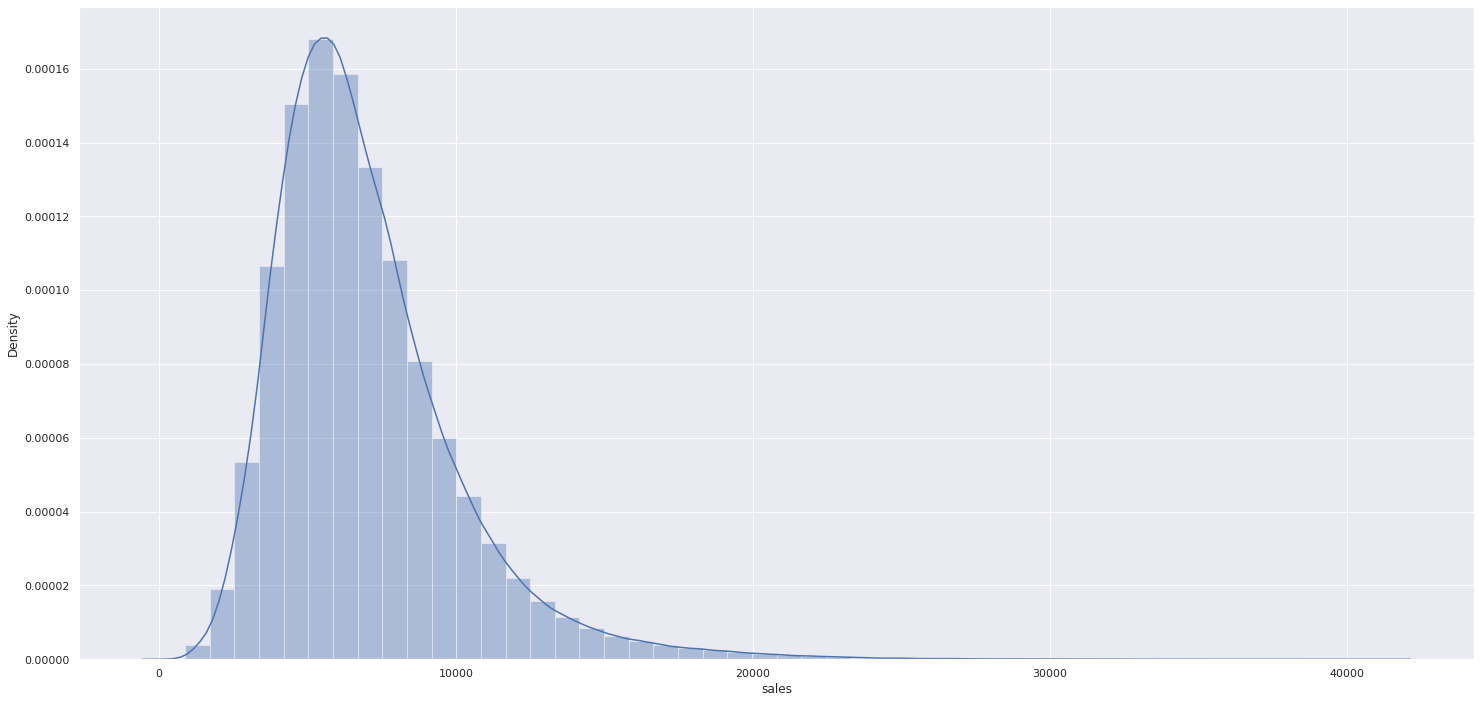

In [36]:
sns.distplot(df4['sales']);

### 4.1.2 Numerical Variable 

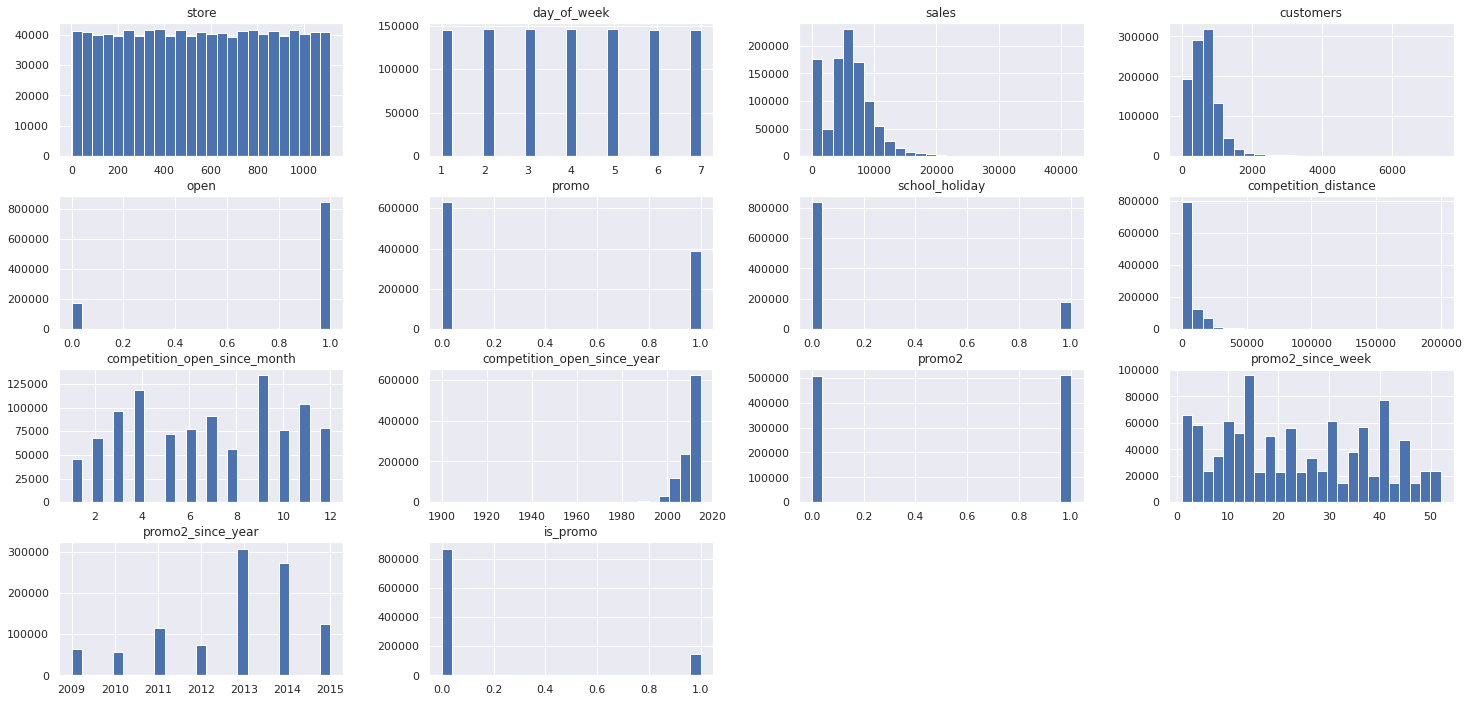

In [37]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical Variable 

In [38]:
cat_attributes.drop_duplicates().head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul
6,0,a,c,0,Jul


In [39]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [40]:
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

In [41]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

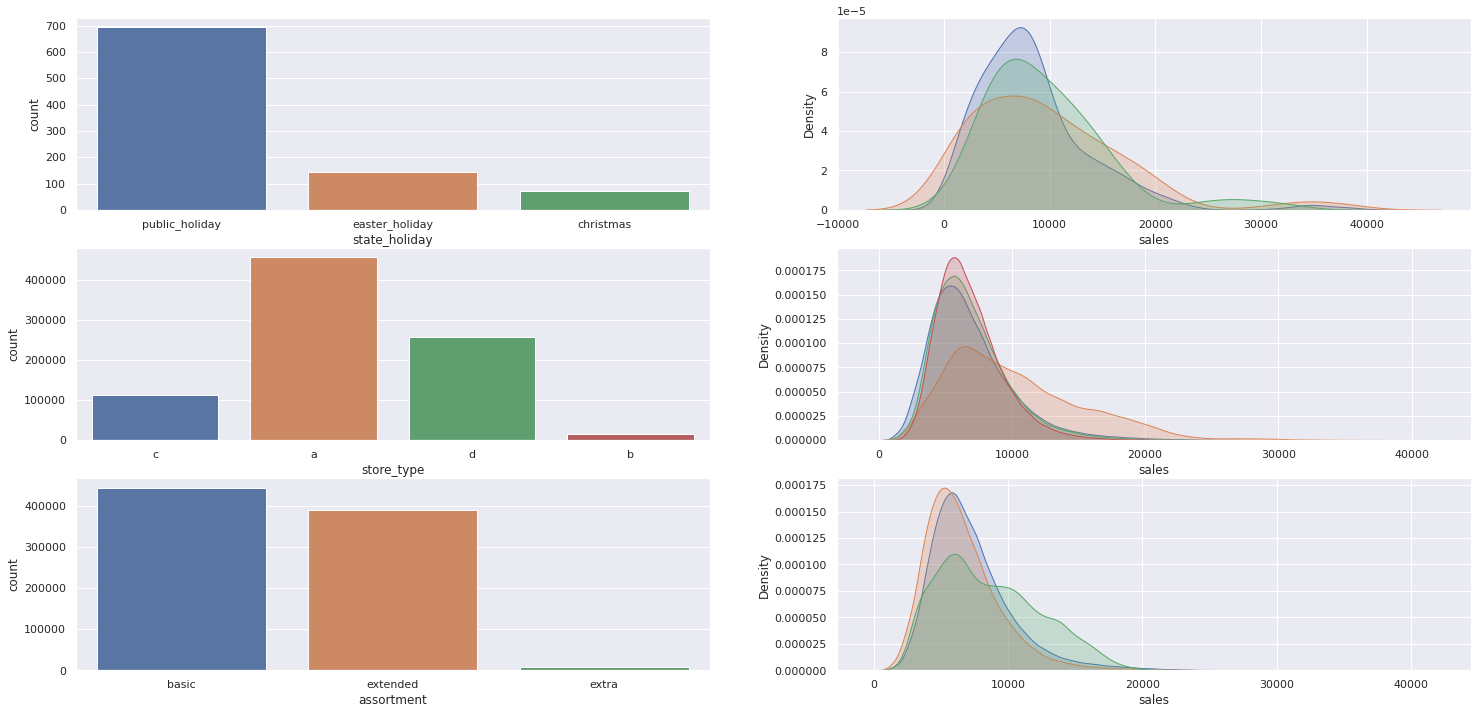

In [42]:
#state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday']!='regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'] , label = 'public_holiday' , shade=True)
sns.kdeplot(df4[df4['state_holiday']=='easter_holiday']['sales'], label ='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday']=='christmas']['sales'] , label='christmas' , shade=True)

#store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type']=='a']['sales'] , label='a' , shade=True)
sns.kdeplot(df4[df4['store_type']=='b']['sales'] , label='b' , shade=True)
sns.kdeplot(df4[df4['store_type']=='c']['sales'] , label='c' , shade=True)
sns.kdeplot(df4[df4['store_type']=='d']['sales'] , label='d' , shade=True)

#assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment']=='extended']['sales'] , label='extended' , shade=True)
sns.kdeplot(df4[df4['assortment']=='basic']['sales'] , label='basic' , shade=True)
sns.kdeplot(df4[df4['assortment']=='extra']['sales'],label='extra' , shade=True)

## 4.1 Análise Bivariada 

### H1 Lojas com maior sortimentos deveriam vender mais. (FALSA)
**1.** Lojas com MAIOR SORTIMENTO vendem MENOS. 

<AxesSubplot:xlabel='year_week'>

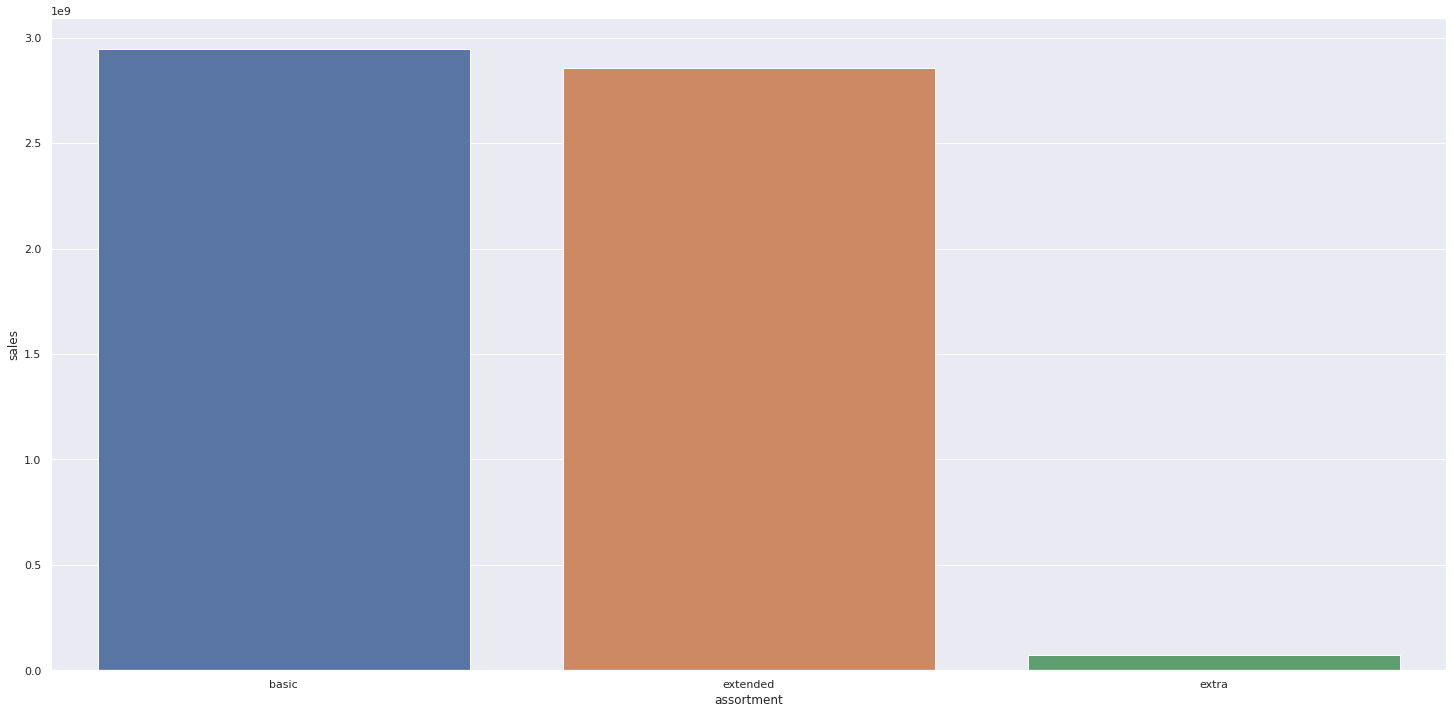

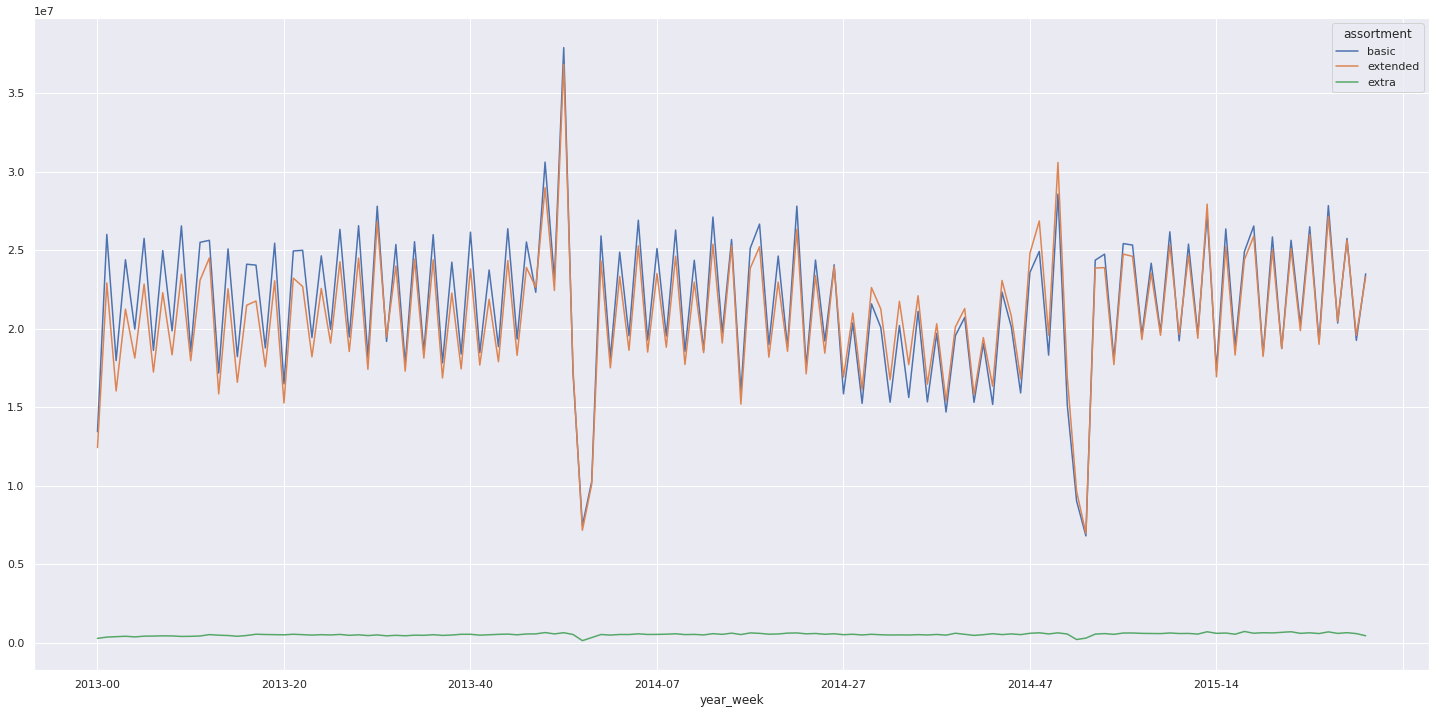

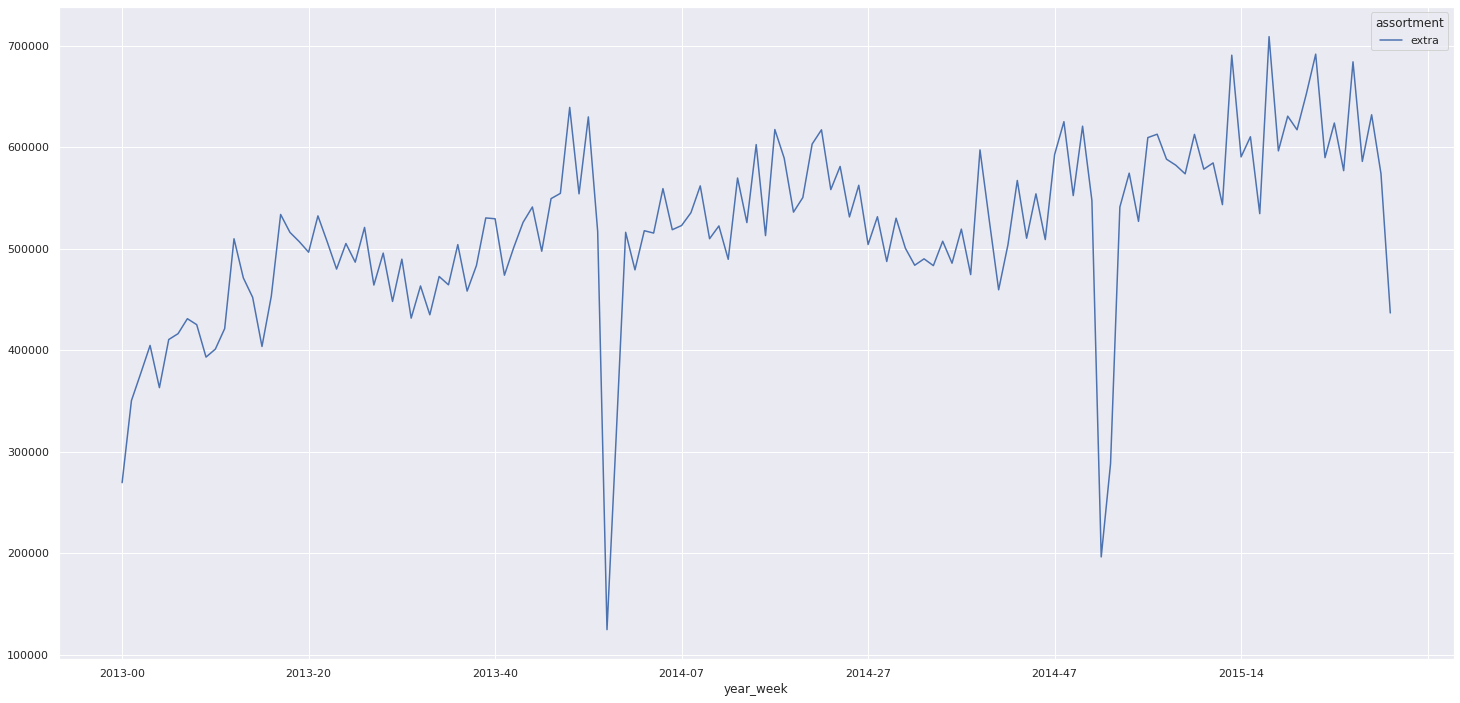

In [43]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment' , y='sales' , data=aux1);

aux2 = df4[['year_week' , 'assortment' , 'sales']].groupby(['assortment','year_week']).sum().reset_index()
aux2.pivot(index = 'year_week' , columns ='assortment' , values='sales' ).plot()

aux3 = aux2[aux2['assortment']=='extra']
aux3.pivot(index='year_week' , columns='assortment' , values='sales').plot()

### H2. Lojas com competidores mais próximos deveriam vender menos. (FALSA)
**2.** Lojas com competidores MAIS PRÓXIMOS vedem MAIS.

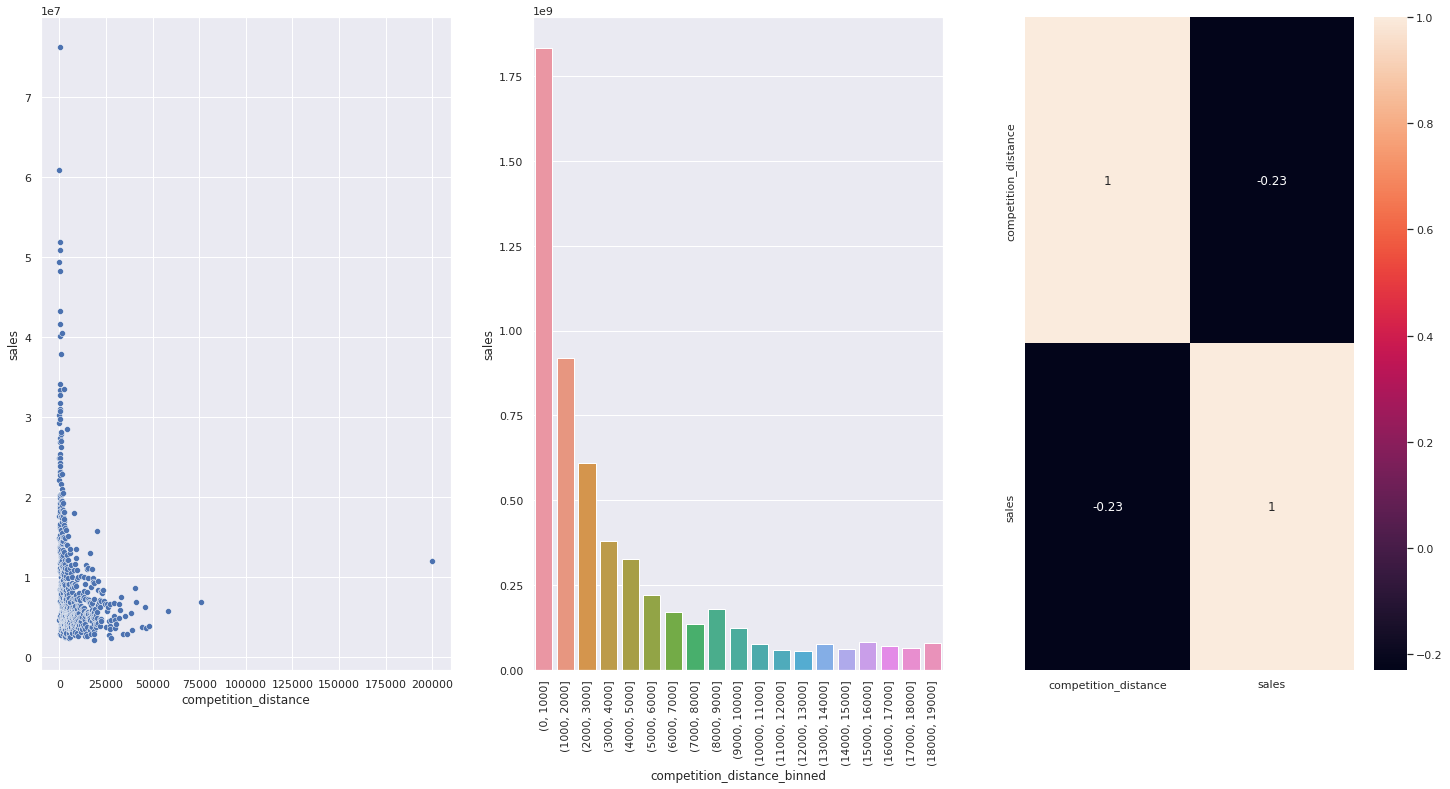

In [44]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance' , y='sales' , data=aux1)

bins = list(np.arange(0,20000,1000))

plt.subplot(1,3,2)
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'],bins=bins)
aux2 = aux1[['competition_distance_binned' , 'sales']].groupby('competition_distance_binned').sum().reset_index()
plt.xticks(rotation=90)
sns.barplot(x='competition_distance_binned' , y='sales' , data=aux2)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

### H3. Lojas com competidores à mais tempo deveriam vender mais. (FALSA)
**3.** Lojas com COMPETIDORES À MAIS TEMPO deveriam vendem MENOS.

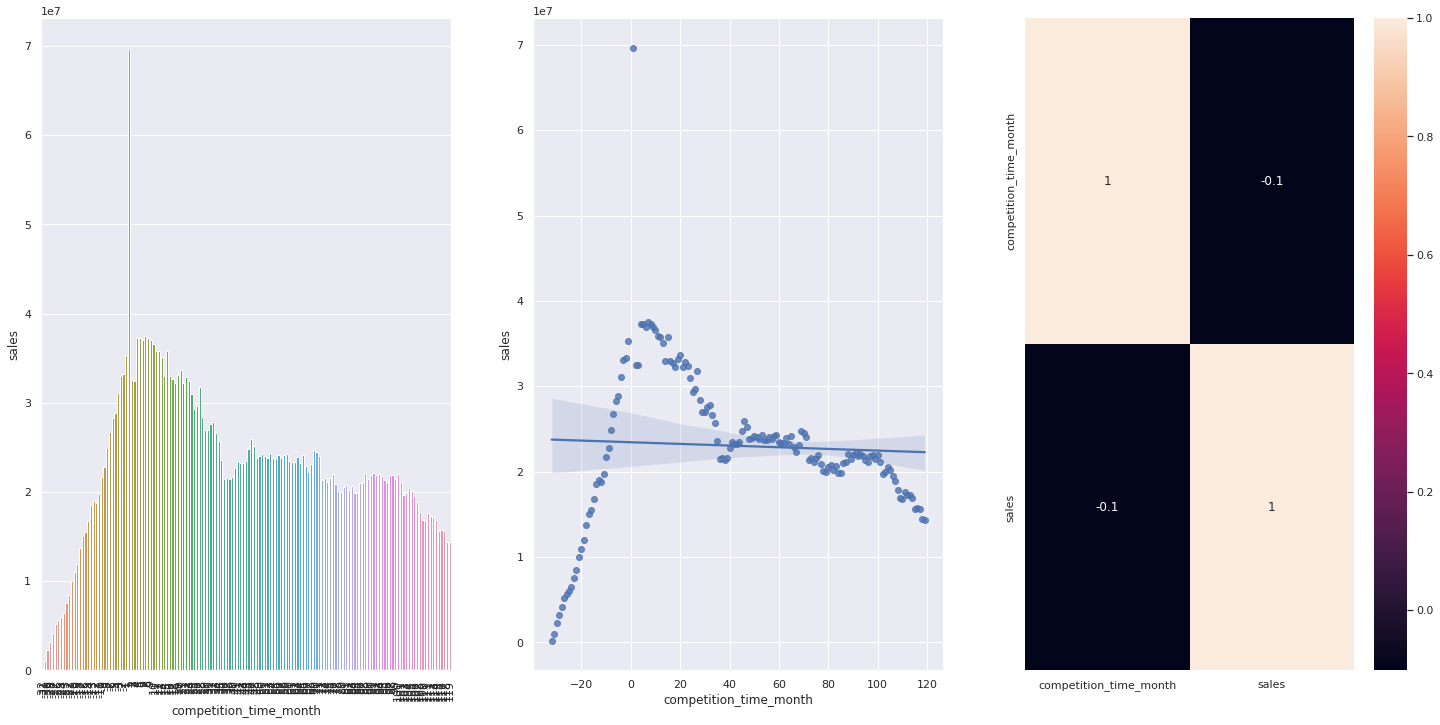

In [45]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month']<120) & (aux1['competition_time_month']!=0)]
sns.barplot(x='competition_time_month' , y='sales' , data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month' , y='sales' , data=aux2)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais(FALSA). 
**4.** Lojas com promoções ativas por mais tempo VENDEM MENOS.

<AxesSubplot:>

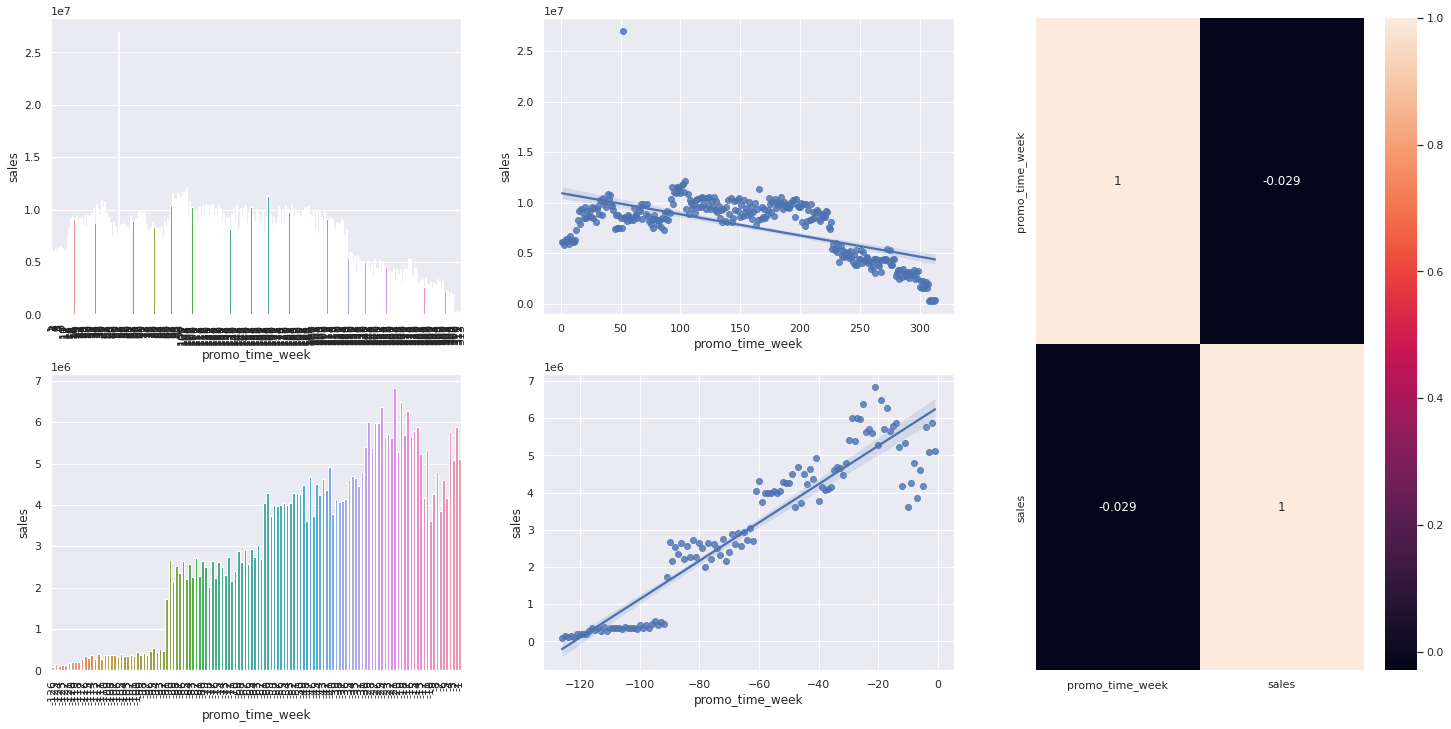

In [46]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2 , 3)
plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0 ] #promo extendido
sns.barplot(x='promo_time_week' , y='sales' , data=aux2)
plt.xticks(rotation=90)

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week' , y='sales' , data=aux2)

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] #promo regular
sns.barplot(x='promo_time_week' , y='sales' , data=aux3)
plt.xticks(rotation=90)

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week' , y='sales' , data=aux3)

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'),annot=True)

### H5. Lojas com mais dias de promoção deveriam vender mais (FALSA).
**5.** Lojas com mais dias de promoção VENDEM menos.

### H6. Lojas com mais promoções consecutivas deveriam vender mais. 
**6.** Lojas com mais promoções consecutivas deveriam vender mais.



In [47]:
df4[['promo' , 'promo2', 'sales']].groupby(['promo' , 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


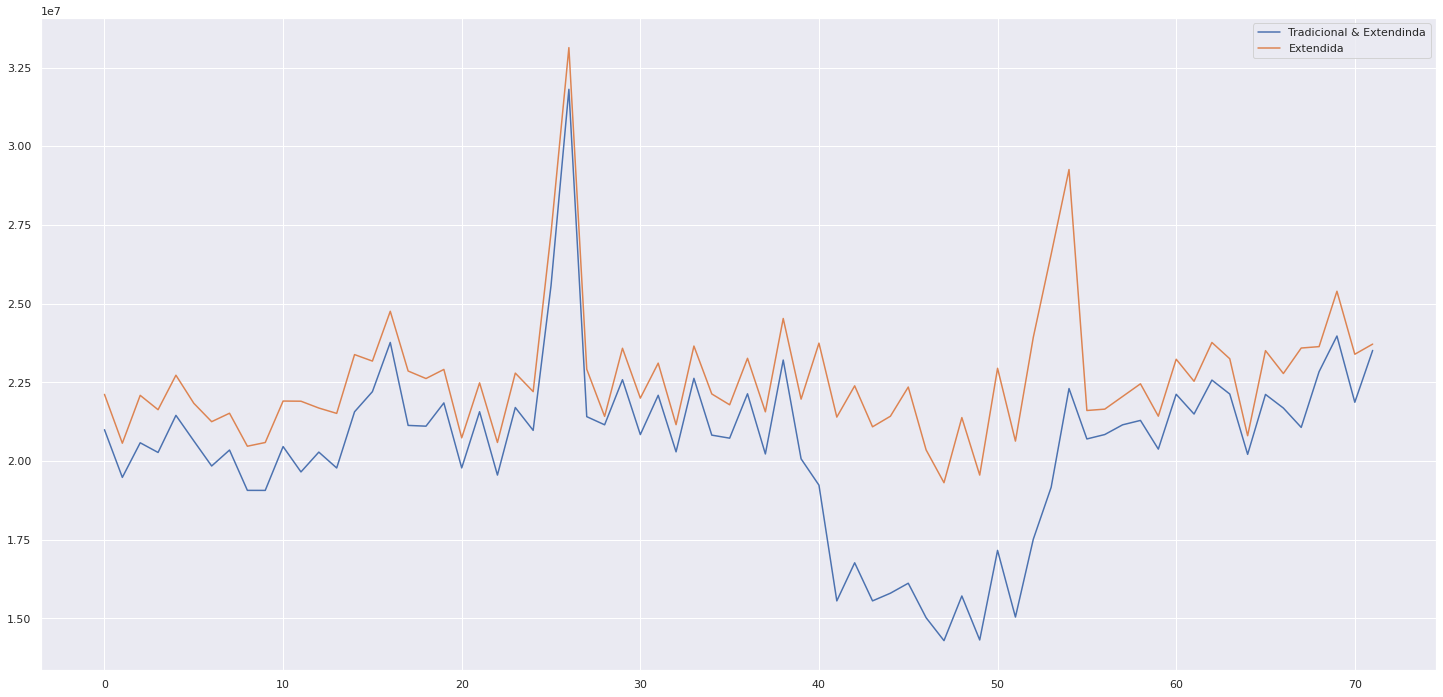

In [48]:
aux1 = df4[(df4['promo']==1)& (df4['promo2']==1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendinda' , 'Extendida'])

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais (FALSA).
**7.** Lojas abertas durante o feriado de Natal deveriam VENDEM menos.

<AxesSubplot:xlabel='year', ylabel='sales'>

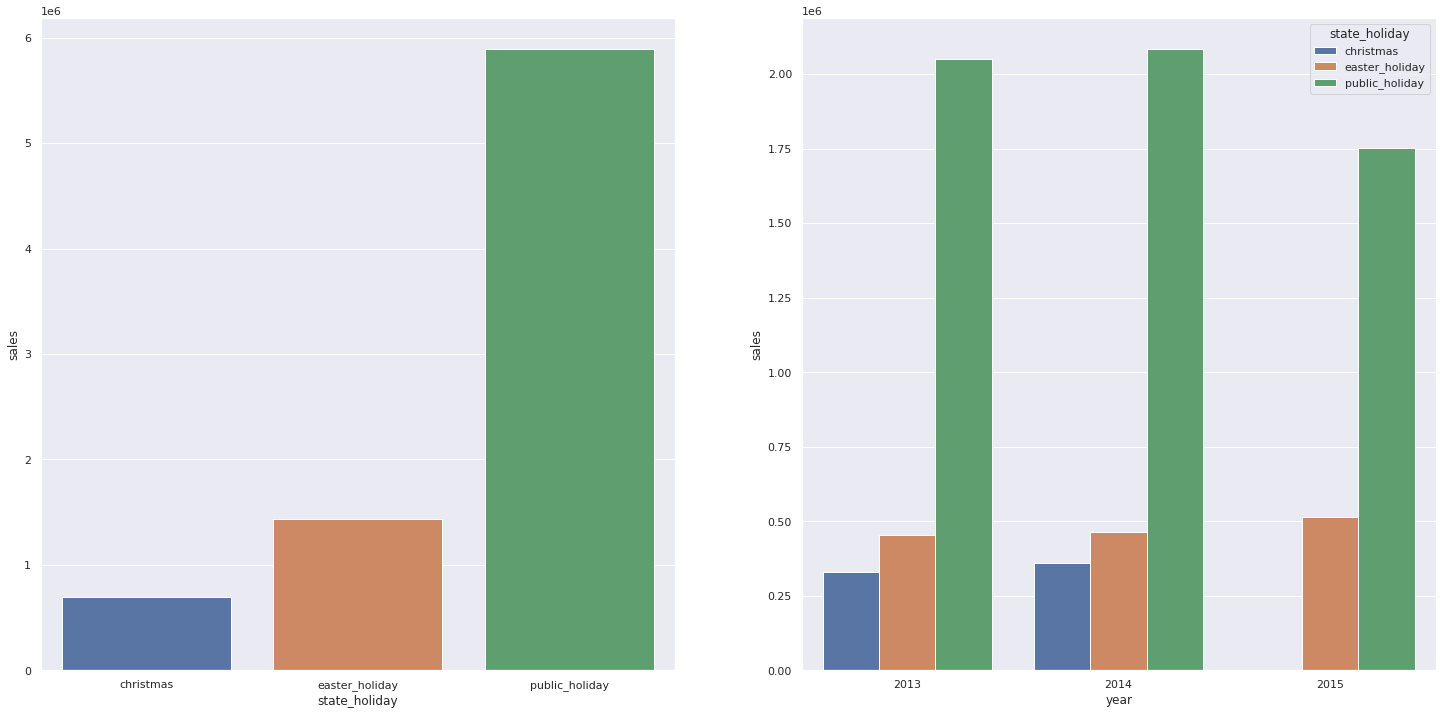

In [49]:
aux = df4[df4['state_holiday'] != 'regular_day']
plt.subplot(1,2,1)
aux1 = aux[['state_holiday' , 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday' , y='sales' , data=aux1)

plt.subplot(1,2,2)
aux2 = aux[['year' , 'state_holiday' , 'sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year' , y='sales' , hue='state_holiday', data=aux2)

### H8. Lojas deveriam vender mais ao longo dos anos.
**8.** Lojas deveriam vender mais ao longo dos anos.

<AxesSubplot:>

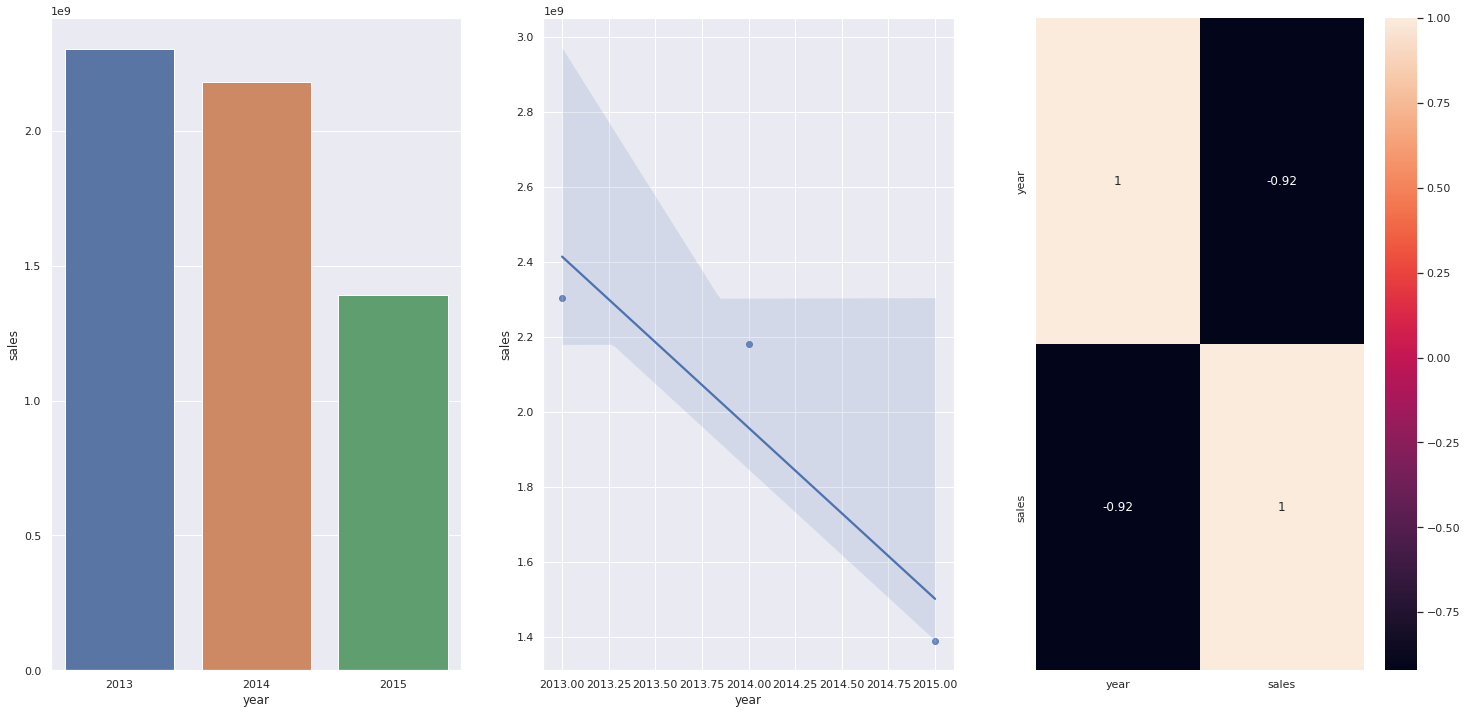

In [50]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year' , y='sales' ,data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='year' , y='sales' , data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

### H9. Lojas deveriam vender mais no segundo semestre do ano (FALSO).
**9.** Lojas VENDEM menos no segundo semestre do ano.


<AxesSubplot:>

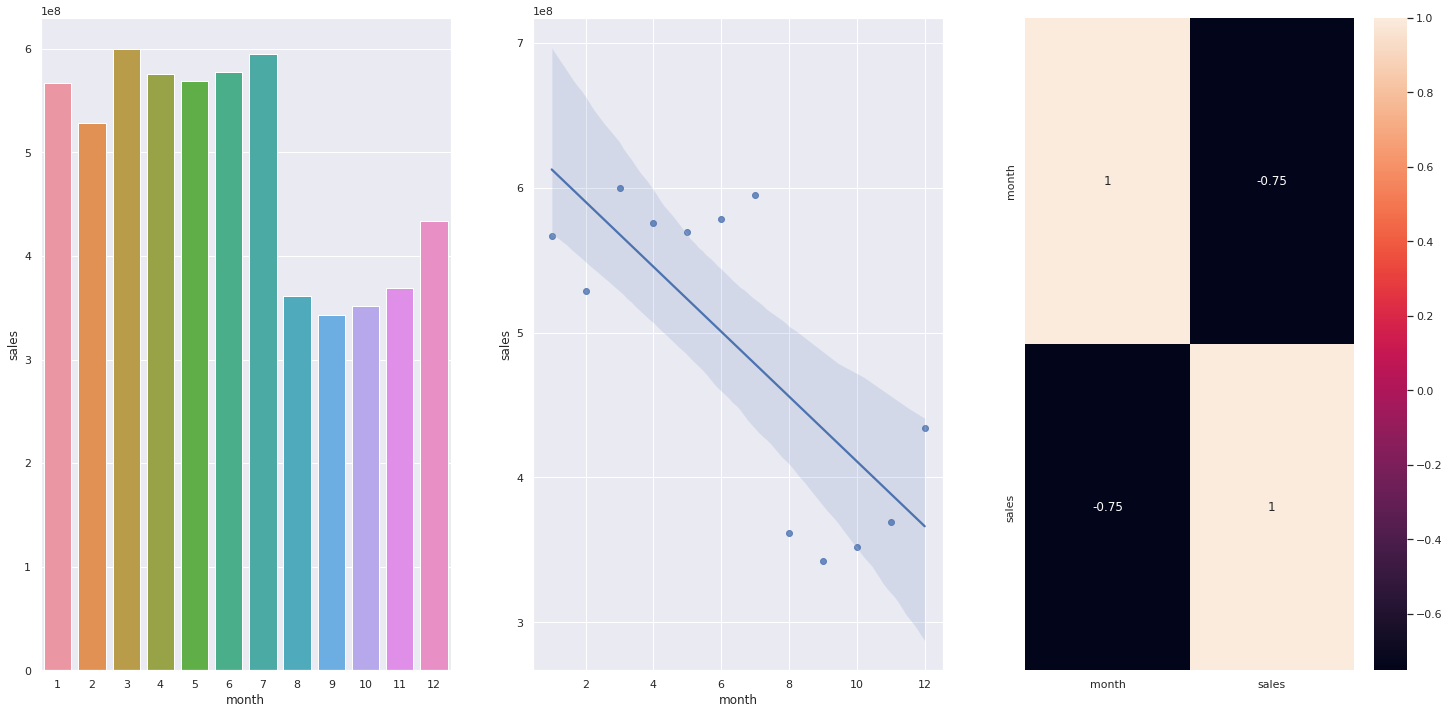

In [51]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month' , y='sales' , data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='month' , y='sales' , data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson') , annot=True)

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês (VERDADEIRA).
**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.


<AxesSubplot:xlabel='before_after', ylabel='sales'>

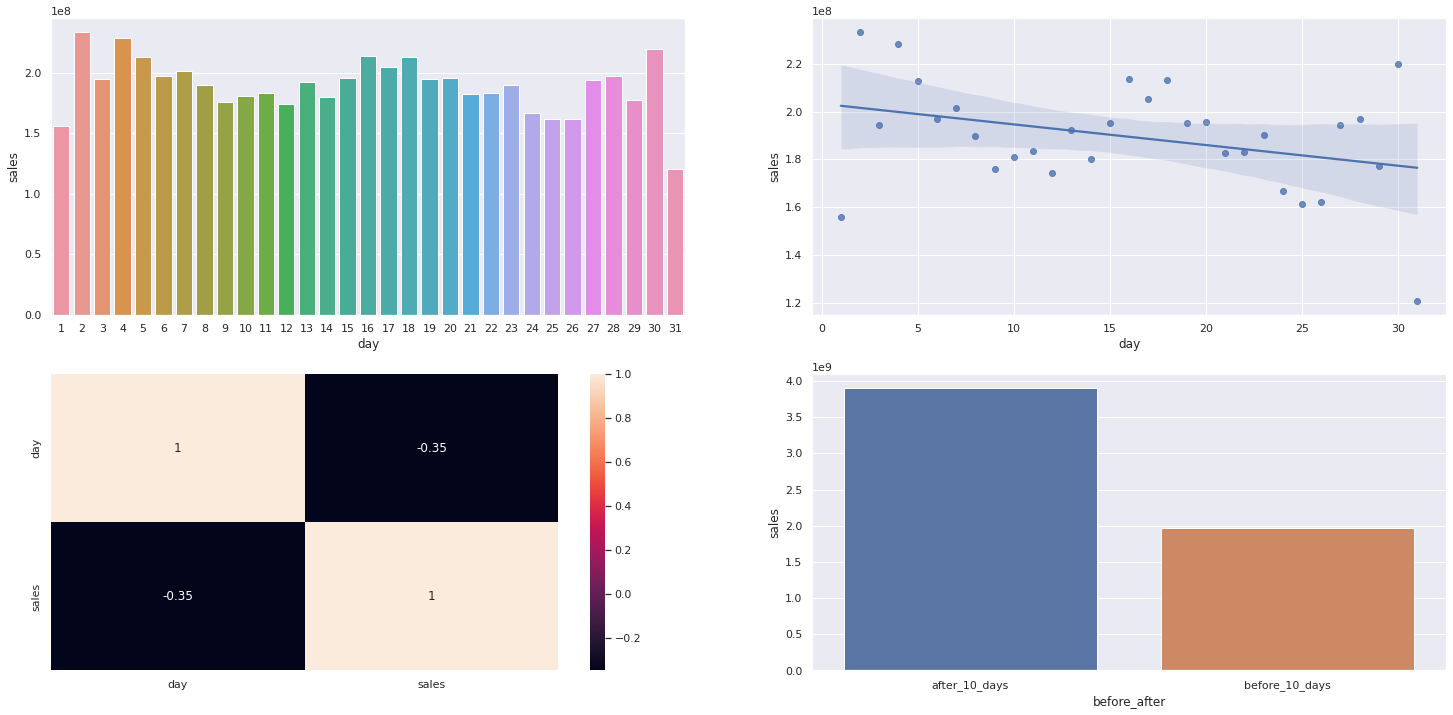

In [52]:
aux1 = df4[['day' , 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day' , y='sales' , data=aux1)

plt.subplot(2,2,2)
sns.regplot(x='day' , y='sales' , data=aux1)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson') , annot=True)

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x<=10 else 'after_10_days')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after' , y='sales' , data=aux2)


<AxesSubplot:xlabel='day', ylabel='sales'>

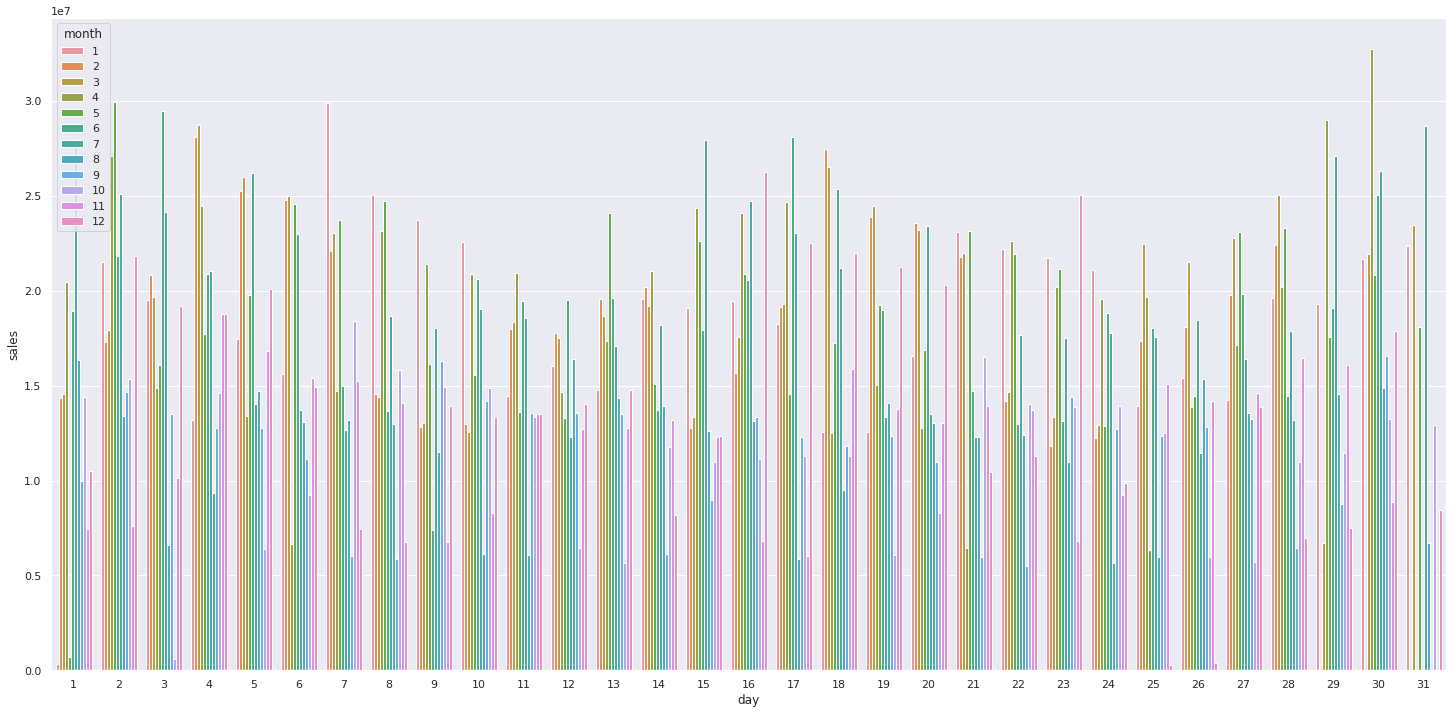

In [53]:
aux1 = df4[['month' , 'day' , 'sales']].groupby(['month' , 'day']).sum().reset_index()
sns.barplot(x='day' , y='sales' , hue='month' , data=aux1)

### H11.  Lojas deveriam vender menos aos finais de semana (VERDADEIRA).
**11.** Lojas vendem menos aos finais de semana.


<AxesSubplot:>

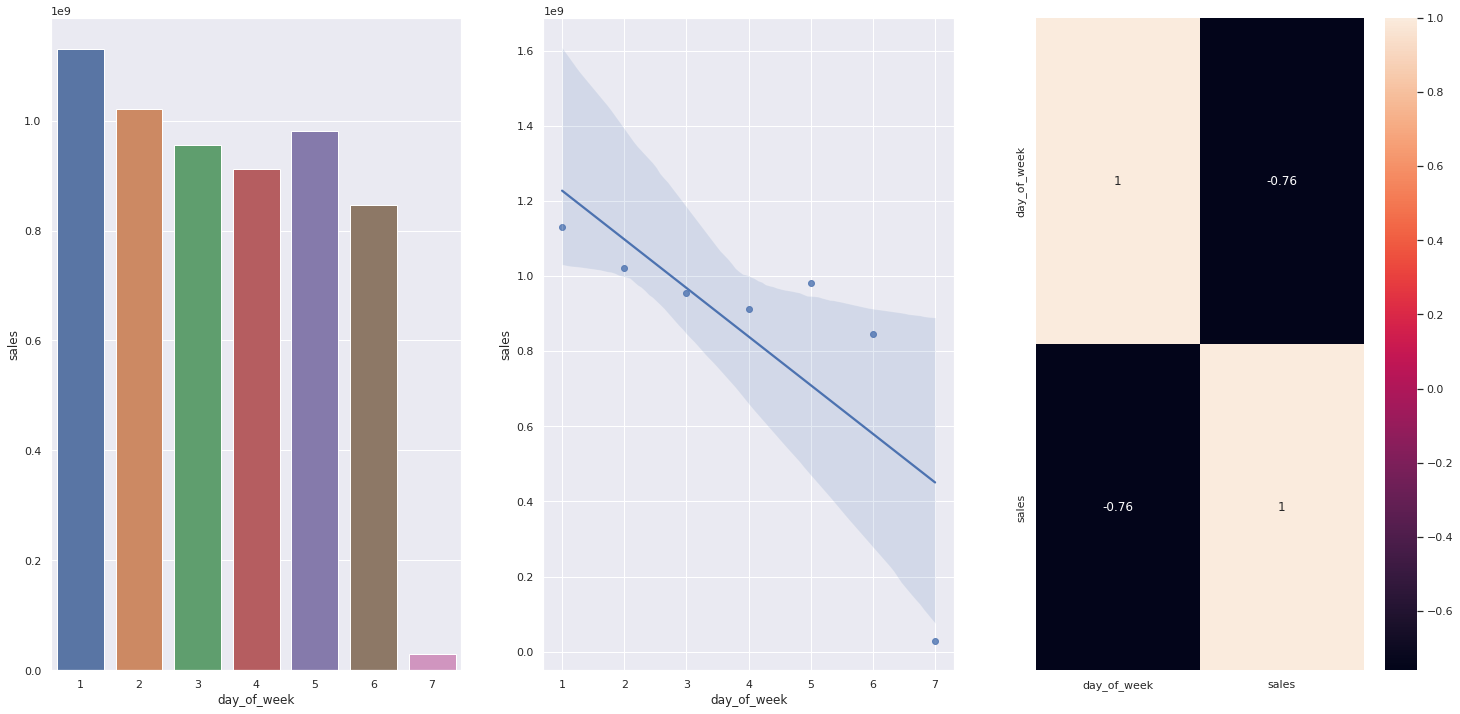

In [54]:
aux1 = df4[['day_of_week' , 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week' , y='sales' , data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='day_of_week' , y='sales',data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H12. Lojas deveriam vender menos durante os feriados escolares.
**12.** Lojas deveriam vender menos durante os feriados escolares.

<AxesSubplot:xlabel='month', ylabel='sales'>

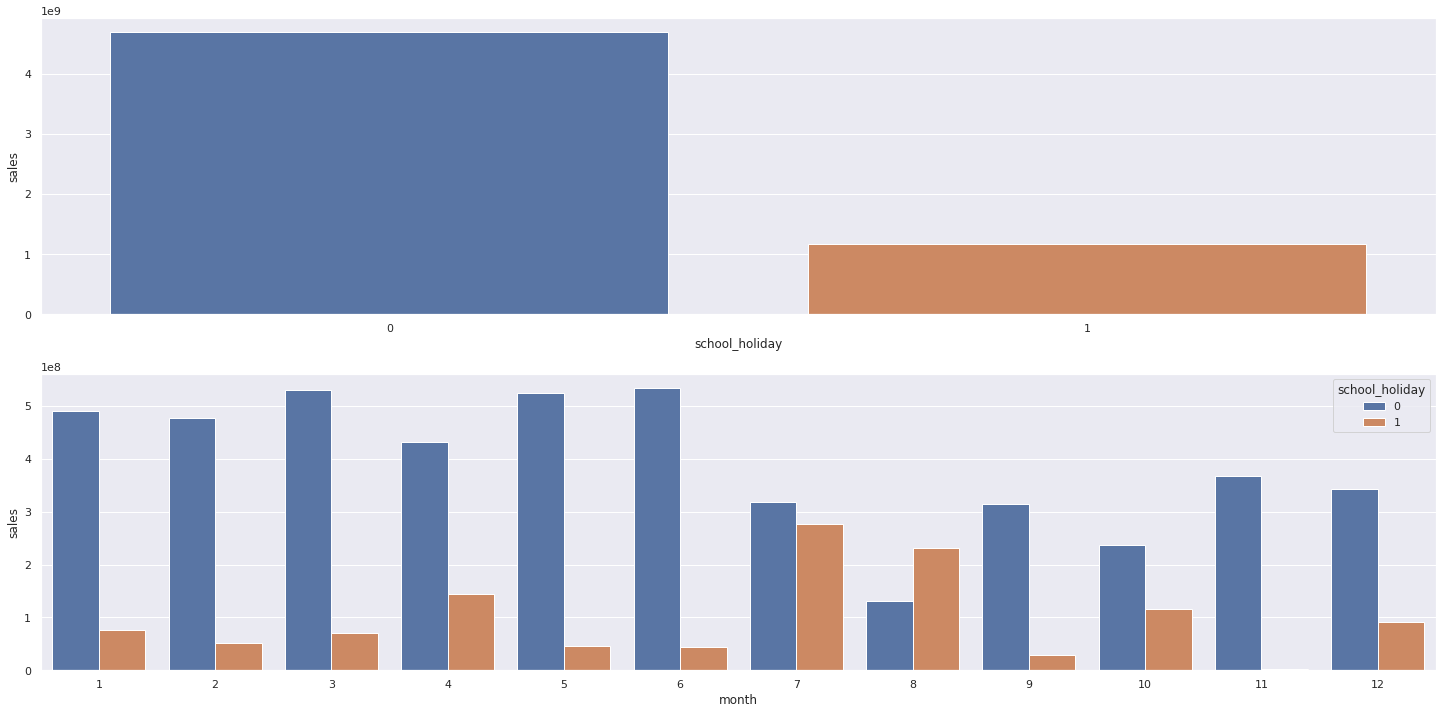

In [55]:
aux1 = df4[['school_holiday' , 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday' , y='sales' , data=aux1)

aux2=df4[['school_holiday' , 'month' , 'sales']].groupby(['school_holiday' , 'month']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month', y='sales' , hue='school_holiday' , data=aux2)

### 4.2.1 Resumo de Hipótesis

In [56]:
from tabulate import tabulate

In [57]:

tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H7', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Alta'],
['H13', 'Verdadeira', 'Baixa'],
]
print(tabulate(tab , headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3 Análise Multivariada 

### 4.3.1 Numerical Attributes

<AxesSubplot:>

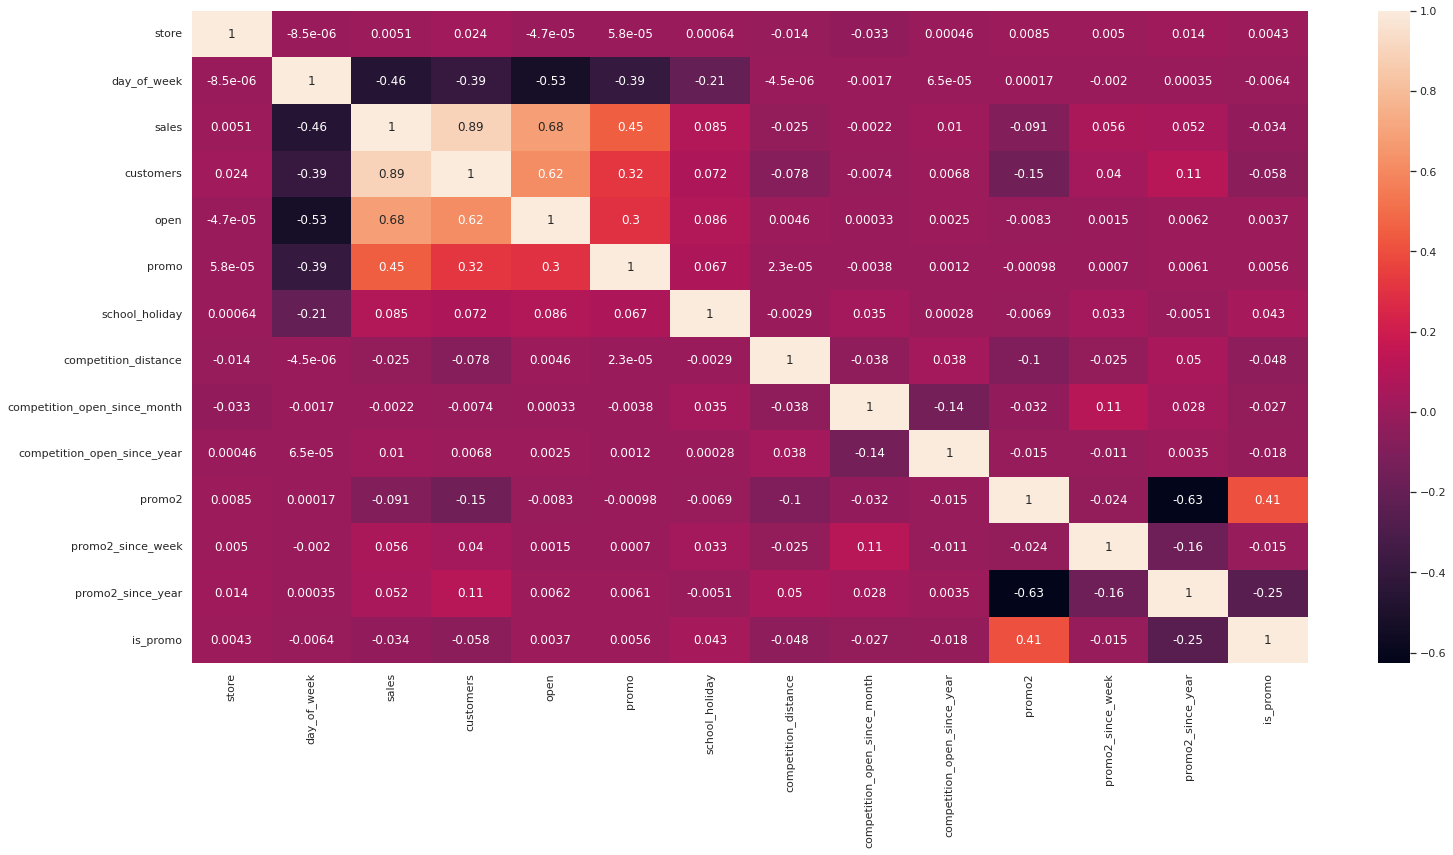

In [58]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation,annot=True)

### 4.3.2 Categorical Attributes

<AxesSubplot:>

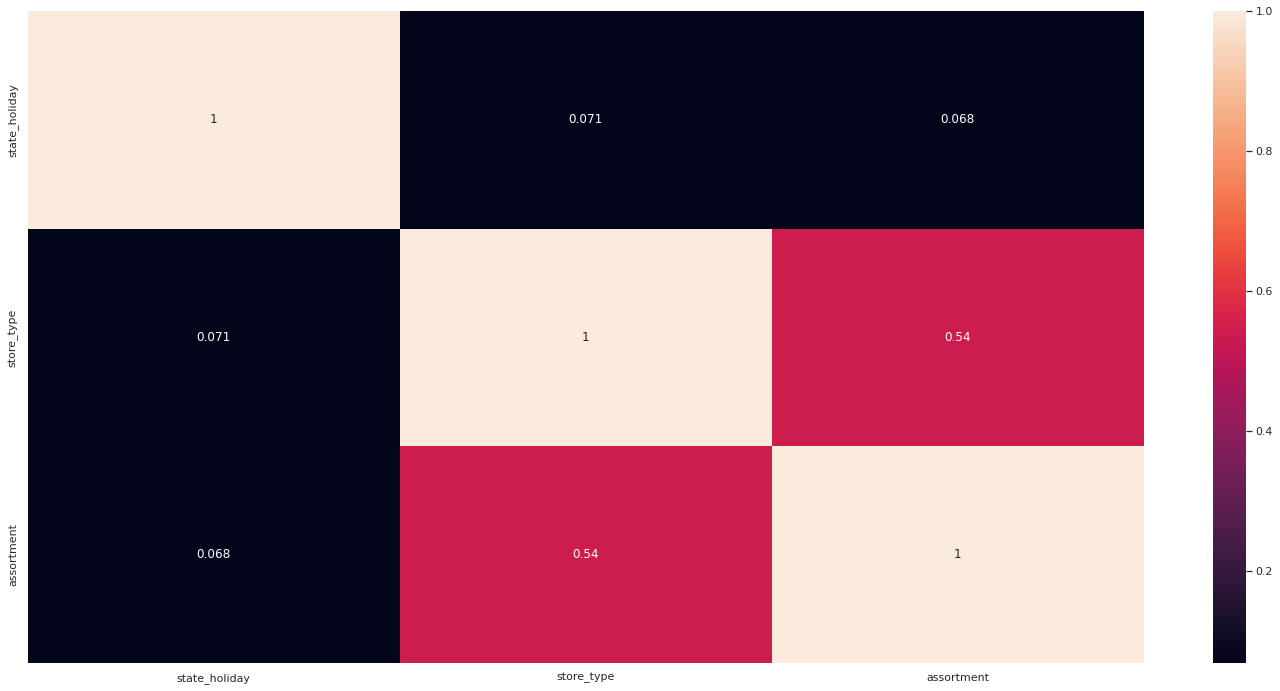

In [59]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 'store_type': [a4, a5, a6], 'assortment': [a7, a8, a9] })

d = d.set_index( d.columns )
sns.heatmap( d, annot=True )

# 5.0 Passo 05 - DATA PREPARATION

In [60]:
df5 = df4.copy()

## 5.1 Normalização

**Normalização é muito utilizada para variáveis com distribuições normais.**

## 5.2 Rescaling

In [61]:
df5.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

In [62]:
#métodos utilizados quando a distribuição não é normal.
rs = RobustScaler()
mms = MinMaxScaler()

#competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

#competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

#promo time week
df5['promo_time_week'] = rs.fit_transform(df5[['promo_time_week']].values)

#year
df5['year'] = rs.fit_transform(df5[['year']].values)

## 5.3 Transformação

### 5.3.1 Encoding 

In [63]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2 Response Variable Transformation

In [64]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 Nature Transformation 

In [65]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x* (2* np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2*  np.pi/7)))

#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x* (2* np.pi/7)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2*  np.pi/7)))

#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x* (2* np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2*  np.pi/30)))

#week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x* (2* np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2*  np.pi/52)))

In [66]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.000000,0,0,0,1,-0.974928,-0.222521,-2.449294e-16,1.0,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,2.559633,0,0,0,1,-0.974928,-0.222521,-2.449294e-16,1.0,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,2.073394,0,0,0,1,-0.974928,-0.222521,-2.449294e-16,1.0,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.000000,0,0,0,1,-0.974928,-0.222521,-2.449294e-16,1.0,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.000000,0,0,0,1,-0.974928,-0.222521,-2.449294e-16,1.0,0.207912,0.978148,-0.568065,-0.822984


# 6.0 Passo 06 - Feature Selection

In [67]:
#Métodos de seleção de variáveis(filter methods - Seleção univariada(ex: correlação), 
#embedded methods-Seleção por importância(ex: rf, lasso, pega os pesos) e wrapper methods - Seleção por subset).

In [68]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [69]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since','competition_since', 'year_week']

df6 = df6.drop(cols_drop,axis=1)

In [70]:
#training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#test dataset
X_test = df6[df6['date']>='2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}' .format(X_train['date'].min() ) )
print('Training Max Date: {}' .format(X_train['date'].max() ) )

print('\nTest Min Date: {}' .format(X_test['date'].min() ) )
print('\nTest Max Date: {}' .format(X_test['date'].max() ) ) 

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00

Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selection

In [71]:
#training and test dataset for Boruta
#X_train_n = X_train.drop(['date','sales'],axis=1).values
#y_train_n = X_train['sales'].values.ravel()

#Define RandomForest Regressor
#rf = RandomForestRegressor(n_jobs=-1)

#define boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### 6.2.1 Best Features from Boruta

In [72]:
#cols_selected = boruta.support_.tolist()

#best features
#X_train_fs = X_train.drop(['date','sales'],axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

#not selected boruta
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns,cols_selected_boruta))

## 6.3 Manual Feature Selection

In [73]:
#cols_selected_boruta

In [74]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

#columns to add
feat_to_add = ['date','sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0 Passo 07 - MACHINE LEARNING MODELLING

In [75]:
x_train = X_train[cols_selected_boruta]
x_test  = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1 Average Model 

In [76]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1,aux2,how='left',on='store')

yhat_baseline = aux1['predictions']
#performance
baseline_result = ml_error('Average Model', np.expm1(y_test),np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2 Linear Regression

In [77]:
lr = LinearRegression().fit(x_train,y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression',np.expm1(y_test),np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.023022,0.292948,2671.800114


### 7.2.1 Linear Regression Model - Cross Validation

In [78]:
lr_result_cv = cross_validation( x_training, 5 , 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2046.02 +/- 261.86,0.3 +/- 0.01,2908.89 +/- 392.31


## 7.3 Linear Regression Regulazired Model - Lasso

In [79]:
lrr = Lasso(alpha=0.001).fit(x_train,y_train)

#prediction
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression Regularized - Lasso', np.expm1(y_test),np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Regularized - Lasso,1867.577799,0.290483,2684.030214


### 7.3.1 Lasso - Cross Validation

In [80]:
lrr_result_cv = cross_validation( x_training, 5 , 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2049.6 +/- 274.99,0.29 +/- 0.01,2931.24 +/- 409.79


## 7.4 Random Forest Regressor

In [81]:
rf = RandomForestRegressor(n_estimators=100,n_jobs=-1,random_state=42).fit(x_train,y_train)

#prediction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test),np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,686.639751,0.100088,1028.114082


### 7.4.1 Random Forest Regressor - Cross Validation

In [82]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=False )
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,828.67 +/- 193.75,0.12 +/- 0.02,1242.95 +/- 291.2


## 7.5 XGB Regressor

In [83]:
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytree=0.9).fit( x_train, y_train )

#prediction
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test),np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6682.880735,0.949409,7329.962032


### 7.5.1 XGB Regressor - Cross Validation

## 7.6 Compare Model's Performance


In [84]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False )
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7049.17 +/- 589.69,0.95 +/- 0.0,7715.34 +/- 690.4


## 7.6.1 Single Performance


In [85]:
modelling_result = pd.concat([baseline_result,lr_result,lrr_result,rf_result,xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,686.639751,0.100088,1028.114082
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1867.023022,0.292948,2671.800114
0,Linear Regression Regularized - Lasso,1867.577799,0.290483,2684.030214
0,XGBoost Regressor,6682.880735,0.949409,7329.962032


## 7.6.2 Real Performance - Cross Validation


In [86]:
modelling_result_cv = pd.concat([lr_result_cv,lrr_result_cv,rf_result_cv,xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,828.67 +/- 193.75,0.12 +/- 0.02,1242.95 +/- 291.2
0,Linear Regression,2046.02 +/- 261.86,0.3 +/- 0.01,2908.89 +/- 392.31
0,Lasso,2049.6 +/- 274.99,0.29 +/- 0.01,2931.24 +/- 409.79
0,XGBoost Regressor,7049.17 +/- 589.69,0.95 +/- 0.0,7715.34 +/- 690.4


# 8.0 PASSO 08 - Hyperparameter fine tuning

## 8.1 Random Search

In [87]:
#param = {
#            'n_estimators': [1500,1700,2500,3000,3500],
#            'eta':[0.01,0.03],
#            'max_depth': [3, 5, 9],
#            'subsample': [0.1, 0.5, 0.7],
#            'colsample_bytree': [0.3, 0.7, 0.9],
#            'min_child_weight': [3, 8, 15]
#}

#MAX_EVAL = 5

In [88]:
#final_result = pd.DataFrame()

#for i in range( MAX_EVAL ):
    
#    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#    print(hp)
    
#    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                                 n_estimators=hp['n_estimators'],
#                                 eta=hp['eta'],
#                                 max_depth=hp['max_depth'],
#                                 subsample=hp['subsample'],
#                                 colsample_bytee=hp['colsample_bytree'],
#                                 min_child_weight=hp['min_child_weight'])
#    result = cross_validation(x_training,5,'XGBoost Regressor', model_xgb,verbose=True)
#    final_result = pd.concat([final_result,result])

#final_result

## 8.2 Final Result

In [89]:
param_tuned = {'n_estimators': 3500, 
               'eta': 0.03, 
               'max_depth': 9, 
               'subsample': 0.7, 
               'colsample_bytree': 0.7, 
               'min_child_weight': 8}

In [90]:
#model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
#                                   n_estimators=param_tuned['n_estimators'],
#                                   eta=param_tuned['eta'],
#                                   max_depth=param_tuned['max_depth'],
#                                   sub sample=param_tuned['subsample'],
#                                   colsample_bytree=param_tuned['colsample_bytree'],
#                                   min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

#yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

#xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
#xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,630.917461,0.090733,924.24029


In [99]:
pickle.dump(model_xgb_tuned, open('/home/erickfog/Comunidade DS/4.DSemProducao/DataScienceInProducao/model/model_rossmann.pkl', 'wb') )

# 9.0 PASSO 09 - Tradução e Interpretação do Erro

In [102]:
df9 = X_test[cols_selected_boruta_full]

#rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 Business Performance

In [105]:
# sum of predictions
df91 = df9[['store','predictions']].groupby('store').sum().reset_index()

#MAE and MAPE
df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'],x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df9_aux2 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAPE'})

#merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2,how='inner',on='store')
df92 = pd.merge(df91, df9_aux3, how='inner' , on='store')

#scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

#order columns
df92 = df92[['store' , 'predictions' , 'worst_scenario' , 'best_scenario' , 'MAE', 'MAPE']]

In [106]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,104439.03125,101144.690738,107733.371762,3294.340512,0.541409
908,909,234532.09375,226786.206968,242277.980532,7745.886782,0.530154
875,876,206585.87500,202654.062160,210517.687840,3931.812840,0.302250
182,183,195178.78125,193700.403588,196657.158912,1478.377662,0.232430
1038,1039,351151.65625,349397.126544,352906.185956,1754.529706,0.231666


<AxesSubplot:xlabel='store', ylabel='MAPE'>

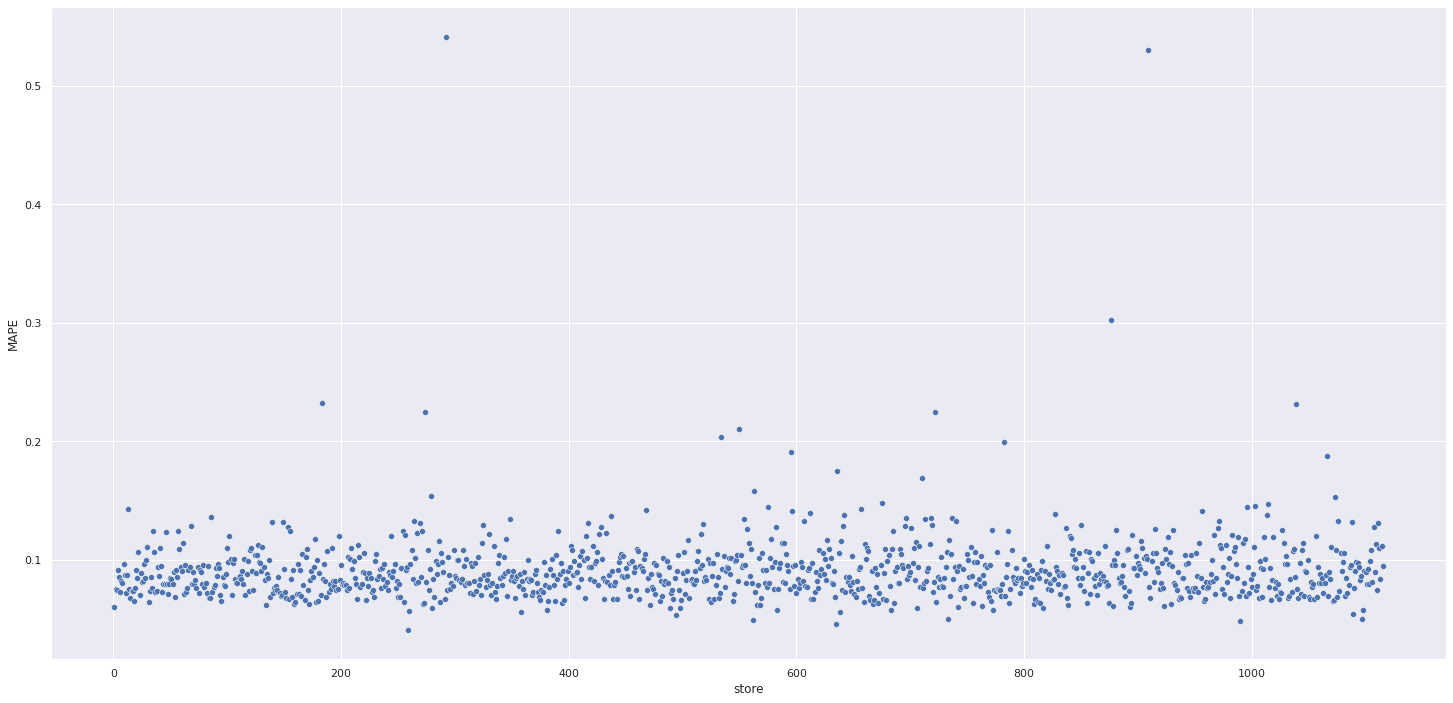

In [107]:
sns.scatterplot(x='store' , y='MAPE' , data=df92)

## 9.2 Total Performance

In [109]:
df93 = df92[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index':'Scenario' , 0:'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$282,127,904.00"
1,worst_scenario,"R$281,420,071.33"
2,best_scenario,"R$282,835,751.87"


## 9.3 Machine Learning Performance

In [110]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions']/df9['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

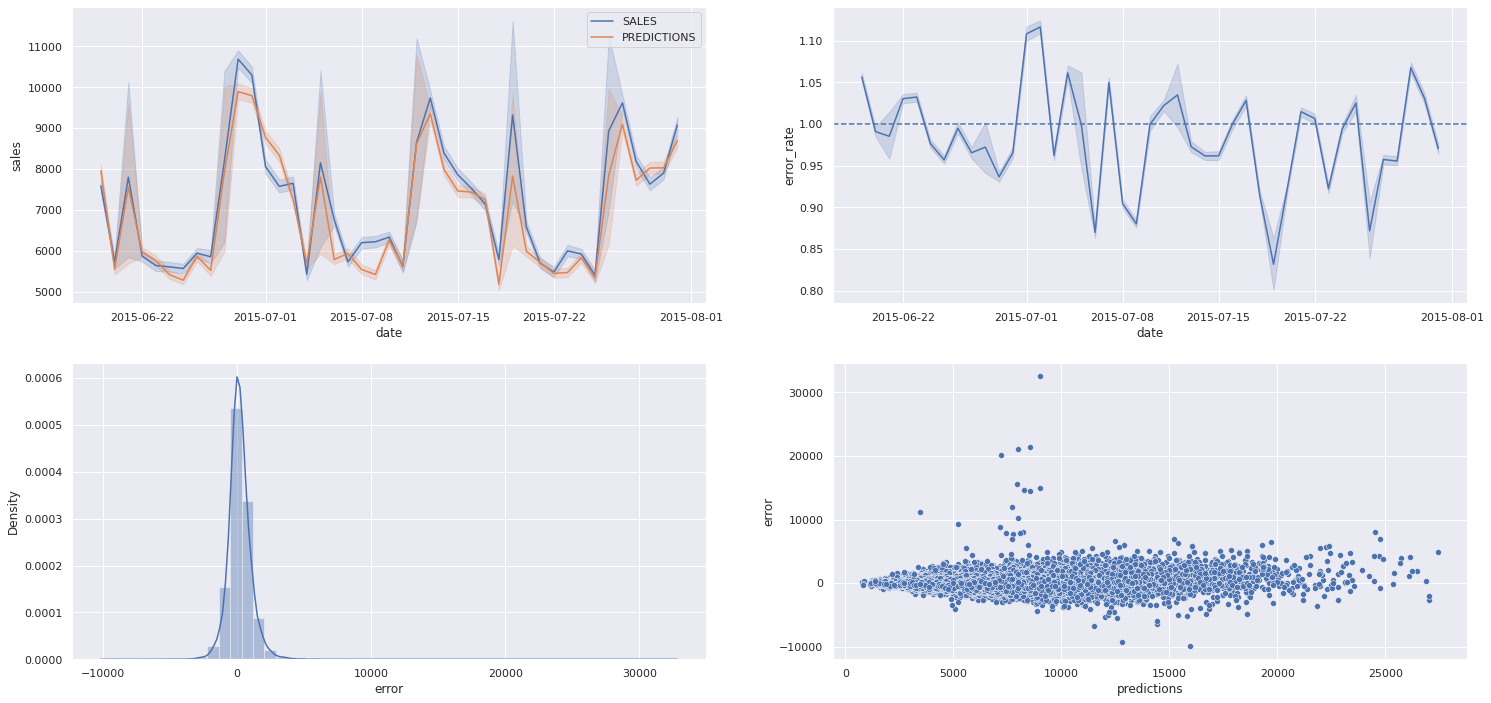

In [118]:
plt.subplot(2,2,1)
sns.lineplot(x='date' , y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2,2,2)
sns.lineplot(x='date',y='error_rate',data=df9)
plt.axhline(1,linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )